In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import callbacks
from scipy.stats import wilcoxon, mannwhitneyu
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_tweets = pd.read_csv('/content/drive/My Drive/thesis/datasets/twitter comments/tweets_sentiment.csv')
df_news = pd.read_csv('/content/drive/My Drive/thesis/datasets/news articles/news_sentiment_updated2.csv')
df_political_news = pd.read_csv('/content/drive/My Drive/thesis/datasets/news articles/political_news_sentiment.csv')

In [ ]:
company_ticker = 'TSLA'
df_tweets.drop(columns='body', inplace=True)
df_tweets = df_tweets[df_tweets['ticker_symbol'] == company_ticker].reset_index(drop=True)
df_news = df_news[df_news['Company'] == 'Tesla'].reset_index(drop=True)

In [ ]:
dates = df_tweets['date'].unique()
avg_sentiment = []
tweets_volume = []

for date in dates:
    temp = df_tweets[df_tweets['date'] == date]
    avg_sentiment.append(temp['sentiment_score'].mean())
    tweets_volume.append(len(temp))
  
df_tweet_scores = pd.DataFrame({'Date':dates, 'Avg_sentiment_tweets':avg_sentiment, '# tweets' : tweets_volume})

In [ ]:
df_news['Sentiment'] = df_news['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

dates = df_news['Date'].unique()
avg_sentiment = []
pos_count = []
neu_count = []
neg_count = []


for date in dates:
    temp = df_news[df_news['Date'] == date]
    avg_sentiment.append(temp['Sentiment'].mean())
    pos_count.append(len(temp[temp['Sentiment'] == 1]))
    neu_count.append(len(temp[temp['Sentiment'] == 0]))
    neg_count.append(len(temp[temp['Sentiment'] == -1]))

df_news_scores = pd.DataFrame({'Date':dates, 'Avg_sentiment_news':avg_sentiment, '# Positive news' : pos_count, 
                               '# Neutral news' : neu_count, '# Negative news' : neg_count})

In [ ]:
df_political_news['Sentiment'] = df_political_news['Sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})

dates = df_political_news['Date'].unique()
avg_sentiment = []
pos_count = []
neu_count = []
neg_count = []


for date in dates:
    temp = df_political_news[df_political_news['Date'] == date]
    avg_sentiment.append(temp['Sentiment'].mean())
    pos_count.append(len(temp[temp['Sentiment'] == 1]))
    neu_count.append(len(temp[temp['Sentiment'] == 0]))
    neg_count.append(len(temp[temp['Sentiment'] == -1]))

df_political_news_scores = pd.DataFrame({'Date':dates, 'Avg_sentiment_polit_news':avg_sentiment, '# Positive polit_news' : pos_count, 
                               '# Neutral polit_news' : neu_count, '# Negative polit_news' : neg_count})

In [ ]:
stock = yf.Ticker(company_ticker)

start = min(df_tweet_scores['Date'])
end = max(df_tweet_scores['Date'])

df = stock.history(start=pd.to_datetime(start).date(), end=pd.to_datetime(end).date())

<Axes: xlabel='Date'>

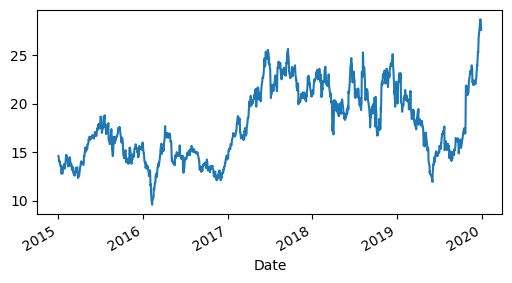

In [ ]:
df['Close'].plot(figsize=(6,3))

In [ ]:
df = df.reset_index()[['Date', 'Close']]
df['Date'] = df['Date'].apply(lambda x: datetime.strftime(pd.to_datetime(x), '%Y-%m-%d'))

df = pd.merge(df,df_tweet_scores,on='Date',how='inner')
df = pd.merge(df,df_news_scores,on='Date',how='inner')
df = pd.merge(df,df_political_news_scores,on='Date',how='left')

In [ ]:
df.fillna(df.mean(), inplace=True)

<ipython-input-11-bf934754a5b1>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


In [ ]:
def processData(data,lb):
    X,Y = [],[]
    data = data.to_numpy()
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

In [ ]:
def processMultiData(data,lb):
    X,Y = [],[]
    df_as_np = data.to_numpy()
    for i in range(len(data)-lb-1):
        row = [r for r in df_as_np[i:i+lb]]
        X.append(row)
        Y.append(df_as_np[i+lb][0])
    return np.array(X),np.array(Y)

In [ ]:
def train_test_data(feature_vector):
  lb=10
  train_size = 0.80

  data = df[feature_vector]
  scl = MinMaxScaler()
  multi_data = data.copy()
  train_data = data[0:int(len(df[['Close']])*0.80)]
  scl.fit(train_data)
  multi_data[feature_vector] = scl.transform(multi_data[feature_vector])

  if len(feature_vector) == 1:
    X,y = processData(multi_data,lb)
  else:
    X,y = processMultiData(multi_data,lb)

  X_train,X_test = X[:int(X.shape[0]*train_size)],X[int(X.shape[0]*train_size):]
  y_train,y_test = y[:int(y.shape[0]*train_size)],y[int(y.shape[0]*train_size):]  

  return X_train, X_test, y_train, y_test, scl

In [ ]:
def create_model(X_train, y_train, feature_number, lb=10):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    model = Sequential()

    model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, 
                   return_sequences=True, input_shape=(lb, feature_number)))
    model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(units=16))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mse')

    earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                            patience=25, restore_best_weights=True)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], feature_number))

    history = model.fit(X_train, y_train, epochs=300, validation_split=0.2,
                        shuffle=False, callbacks=[earlystopping])

    return model

In [ ]:
def make_predictions(X_test, y_test, model, feature_vector, scl):
  Xt = model.predict(X_test)
  Xt = Xt.flatten()
  some_features_actual = {"Actual":y_test}
  some_features_predicted = {"Predicted":Xt}

  for i in range(len(feature_vector) - 1):
    some_features_actual["null_val" + str(i)] = [0]* len(y_test)
    some_features_predicted["null_val" + str(i)] = [0]* len(Xt)
  
  df_actual = pd.DataFrame(some_features_actual)
  df_actual[list(some_features_actual.keys())] = scl.inverse_transform(df_actual[list(some_features_actual.keys())])

  df_predicted = pd.DataFrame(some_features_predicted)
  df_predicted[list(some_features_predicted.keys())] = scl.inverse_transform(df_predicted[list(some_features_predicted.keys())])

  test_rmse = math.sqrt(mean_squared_error(df_actual.Actual,df_predicted.Predicted))
  test_mae = mean_absolute_error(df_actual.Actual,df_predicted.Predicted) 


  y_pred_diff = [list(df_predicted.Predicted)[i] - list(df_predicted.Predicted)[i-1] for i in range(1, len(list(df_predicted.Predicted)))]
  y_test_diff = [list(df_actual.Actual)[i] - list(df_actual.Actual)[i-1] for i in range(1, len(list(df_actual.Actual)))]

  y_pred_movement = [1 if diff > 0 else 0 for diff in y_pred_diff]
  y_test_movement = [1 if diff > 0 else 0 for diff in y_test_diff]

  accuracy = sum([1 for pred, actual in zip(y_pred_movement, y_test_movement) if pred == actual]) / len(y_test_movement)

  return test_rmse, test_mae, accuracy, list(df_predicted.Predicted)

In [2]:
#Wilcoxon Signed Rank Test

def wilcoxon_signed_rank_test(arr1, arr2, metric):
  if metric != 'accuracy':
    statistic, p_value = wilcoxon(arr1, arr2, alternative='greater')
  else:
    statistic, p_value = wilcoxon(arr1, arr2, alternative='less')
  alpha = 0.05
  if p_value < alpha:
    return False #there is a difference
  return True #no difference

In [3]:
#Mann-Whitney U test

def mannwhitneyu_test(arr1, arr2, metric):
  if metric != 'accuracy':
    statistic, p_value = mannwhitneyu(arr1, arr2, alternative='greater')
  else:
    statistic, p_value = mannwhitneyu(arr1, arr2, alternative='less')
  alpha = 0.05
  if p_value < alpha:
    return False #there is a difference
  return True #no difference

In [4]:
model_results = {
    'Prices' : [['Close'], [], [], []],
    'Prices + Tweets' : [['Close', 'Avg_sentiment_tweets'], [], [], []],
    'Prices + News' : [['Close', 'Avg_sentiment_news', '# Positive news', '# Neutral news', '# Negative news'], [], [], []],
    'Prices + Political News' : [['Close', 'Avg_sentiment_polit_news', '# Positive polit_news', '# Neutral polit_news', '# Negative polit_news'], [], [], []],
    'Prices + Tweets + News' : [['Close', 'Avg_sentiment_tweets', 'Avg_sentiment_news', '# Positive news', '# Neutral news', '# Negative news'], [], [], []],
    'Prices + Tweets + Political News' : [['Close', 'Avg_sentiment_tweets', 'Avg_sentiment_polit_news', '# Positive polit_news', '# Neutral polit_news', '# Negative polit_news'], [], [], []],
    'Prices + News + Political News' : [['Close', 'Avg_sentiment_news', '# Positive news', '# Neutral news', '# Negative news', 'Avg_sentiment_polit_news', '# Positive polit_news', '# Neutral polit_news', '# Negative polit_news'], [], [], []],
    'Prices + Tweets + News + Political News' : [['Close', 'Avg_sentiment_tweets', 'Avg_sentiment_news', '# Positive news', '# Neutral news', '# Negative news', 'Avg_sentiment_polit_news', '# Positive polit_news', '# Neutral polit_news', '# Negative polit_news'], [], [], []]
}

In [5]:
test_results = {
    'RMSE Wilcoxon' : [],
    'MAE Wilcoxon' : [],
    'Accuracy Wilcoxon' : [],
    'RMSE Mann-Whitney' : [],
    'MAE Mann-Whitney' : [],
    'Accuracy Mann-Whitney' : []
}

In [ ]:
for i in range(10):
  for key, item in model_results.items():
    feature_vector = model_results[key][0]
    X_train, X_test, y_train, y_test, scl = train_test_data(feature_vector)
    model = create_model(X_train, y_train, len(feature_vector))
    test_rmse, test_mae, accuracy, predicted_values = make_predictions(X_test, y_test, model, feature_vector, scl)
    model_results[key][1].append(round(test_rmse, 2))
    model_results[key][2].append(round(test_mae, 2))
    model_results[key][3].append(round(accuracy, 2))

Streaming output truncated to the last 5000 lines.
24/24 [==============================] - 3s 103ms/step - loss: 0.0112 - val_loss: 0.0087
Epoch 41/300
24/24 [==============================] - 2s 92ms/step - loss: 0.0109 - val_loss: 0.0151
Epoch 42/300
24/24 [==============================] - 2s 95ms/step - loss: 0.0106 - val_loss: 0.0114
Epoch 43/300
24/24 [==============================] - 2s 90ms/step - loss: 0.0105 - val_loss: 0.0113
Epoch 44/300
24/24 [==============================] - 2s 95ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 45/300
24/24 [==============================] - 3s 119ms/step - loss: 0.0092 - val_loss: 0.0135
Epoch 46/300
24/24 [==============================] - 3s 119ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 47/300
24/24 [==============================] - 2s 93ms/step - loss: 0.0098 - val_loss: 0.0150
Epoch 48/300
24/24 [==============================] - 2s 97ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 49/300
24/24 [==============================

In [ ]:
with open('/content/drive/My Drive/thesis/notebooks/TESLA/model results/tesla lstm results.json', "w") as file:
    json.dump(model_results, file)

In [8]:
#test for RMSE values


baseline_rmse = model_results['Prices'][1]
for key, item in model_results.items():
  if key != 'Prices':
    wilcoxon_rmse_result = wilcoxon_signed_rank_test(baseline_rmse, item[1], 'rmse')
    mannwhitneyu_rmse_result = mannwhitneyu_test(baseline_rmse, item[1], 'rmse')

    test_results['RMSE Wilcoxon'].append(['Prices', key, wilcoxon_rmse_result])
    test_results['RMSE Mann-Whitney'].append(['Prices', key, mannwhitneyu_rmse_result])

In [9]:
#test for MAE values


baseline_rmse = model_results['Prices'][2]
for key, item in model_results.items():
  if key != 'Prices':
    wilcoxon_rmse_result = wilcoxon_signed_rank_test(baseline_rmse, item[2], 'mae')
    mannwhitneyu_rmse_result = mannwhitneyu_test(baseline_rmse, item[2], 'mae')
    
    test_results['RMSE Wilcoxon'].append(['Prices', key, wilcoxon_rmse_result])
    test_results['RMSE Mann-Whitney'].append(['Prices', key, mannwhitneyu_rmse_result])

In [10]:
#test for accuracy values


baseline_rmse = model_results['Prices'][3]
for key, item in model_results.items():
  if key != 'Prices':
    wilcoxon_rmse_result = wilcoxon_signed_rank_test(baseline_rmse, item[3], 'accuracy')
    mannwhitneyu_rmse_result = mannwhitneyu_test(baseline_rmse, item[3], 'accuracy')
    
    test_results['RMSE Wilcoxon'].append(['Prices', key, wilcoxon_rmse_result])
    test_results['RMSE Mann-Whitney'].append(['Prices', key, mannwhitneyu_rmse_result])

In [10]:
with open('/content/drive/My Drive/thesis/notebooks/TESLA/model results/tesla lstm test results.json', "w") as file:
    json.dump(test_results, file)